# EYE FOR BLIND

In [1]:
#Import all the required libraries
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import pandas as pd
import glob
import matplotlib.pyplot as plt
from collections import Counter
from pickle import dump, load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add

from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from PIL import Image

%matplotlib inline

Using TensorFlow backend.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Import the dataset and read the image into a seperate variable

images='Flickr8K/Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [3]:
#Visualise both the images & text present in the dataset

text_file = 'Flickr8K/captions.txt'    

def make_dataset(text):
  df = []
  for sentences in text.split('\n'):
      splitted = sentences.split(',')
      if len(splitted) == 1:
          continue
      w = splitted[0].split(",")
      df.append(w + [splitted[1].lower()])
  return df

In [4]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

doc = load_doc(text_file)
print(doc[:250])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse 


In [5]:
doc = doc[14:]

In [6]:
df = make_dataset(doc)
df[:50]

[['1000268201_693b08cb0e.jpg',
  'a child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1000268201_693b08cb0e.jpg', 'a girl going into a wooden building .'],
 ['1000268201_693b08cb0e.jpg',
  'a little girl climbing into a wooden playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  'a little girl climbing the stairs to her playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  'a little girl in a pink dress going into a wooden cabin .'],
 ['1001773457_577c3a7d70.jpg', 'a black dog and a spotted dog are fighting'],
 ['1001773457_577c3a7d70.jpg',
  'a black dog and a tri-colored dog playing with each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  'a black dog and a white dog with brown spots are staring at each other in the street .'],
 ['1001773457_577c3a7d70.jpg',
  'two dogs of different breeds looking at each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  'two dogs on pavement moving toward each other .'],
 ['1002674143_1b742ab4b8.jpg',
  'a little girl 

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
tot_num_images = len(df)

In [8]:
all_img_id= [i for i in range(0,5)]*len(all_imgs) #store all the image id here
all_img_vector= [df[:][i][0] for i in range(0, tot_num_images)] #store all the image path here
annotations= [df[:][i][1] for i in range(0, tot_num_images)] #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
5,0,1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting
6,1,1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with...
7,2,1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spots a...
8,3,1001773457_577c3a7d70.jpg,two dogs of different breeds looking at each o...
9,4,1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .


In [9]:
df.shape

(40455, 3)

In [10]:
#Create the vocabulary & the counter for the captions

def create_vocabulary(df):
  vocab = []
  for captions in df.Captions.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

vocabulary= create_vocabulary(df)

Vocabulary Size : 8871


In [11]:
def df_word_count(data,vocabulary):
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfwordcount = df_word_count(df,vocabulary)

In [12]:
dfwordcount.iloc[:20,:]

,word,count
0,a,60196
1,.,34205
2,in,18174
3,the,17507
4,on,10357
5,is,9069
6,and,8057
7,dog,7948
8,with,7304
9,man,7137


In [13]:
import string
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [14]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(df.Captions.values):
    newcaption = text_clean(caption)
    df["Captions"].iloc[i] = newcaption

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
clean_vocabulary = create_vocabulary(df)

dfwordcount_clean = df_word_count(df,clean_vocabulary)

Vocabulary Size : 8182


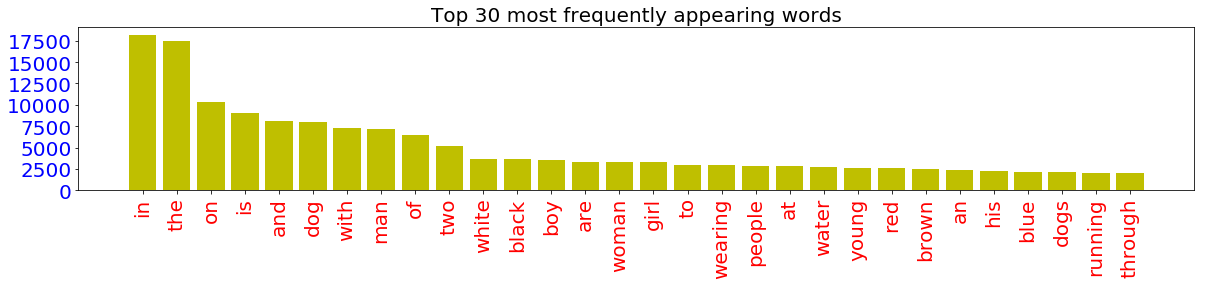

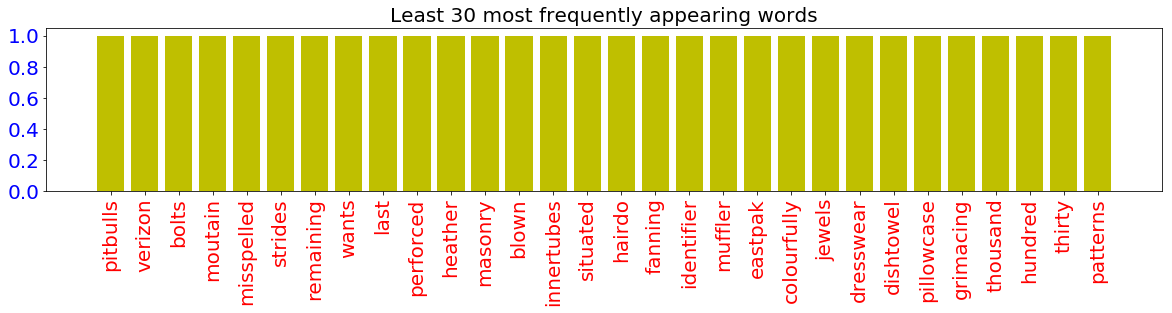

In [16]:
#Visualise the top 30 occuring words in the captions

top30 = 30

def plot_freq_words(dfsub, title="Top 30 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"],color ='y')
    plt.yticks(fontsize=20,color ='b')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='r')
    plt.title(title,fontsize=20)
    plt.show()

plot_freq_words(dfwordcount_clean.iloc[:top30,:],
        title="Top 30 most frequently appearing words")

# Lets also visulaize the bottom 30 occuring words in the captions
plot_freq_words(dfwordcount_clean.iloc[-top30:,:],
        title="Least 30 most frequently appearing words")

In [17]:
#We already have created a list which contains all the captions called `annotations`

#add the <start> & <end> token to all those captions as well

start_annotations_end = ['<start> '+ i + ' <end>' for i in annotations]

#Create a list which contains all the path to the images
all_img_path= ['Flickr8K/Images/' + i for i in all_img_vector]

print("Total captions present in the dataset: "+ str(len(start_annotations_end)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [18]:
all_img_path[:10], start_annotations_end[:10]

(['Flickr8K/Images/1000268201_693b08cb0e.jpg',
  'Flickr8K/Images/1000268201_693b08cb0e.jpg',
  'Flickr8K/Images/1000268201_693b08cb0e.jpg',
  'Flickr8K/Images/1000268201_693b08cb0e.jpg',
  'Flickr8K/Images/1000268201_693b08cb0e.jpg',
  'Flickr8K/Images/1001773457_577c3a7d70.jpg',
  'Flickr8K/Images/1001773457_577c3a7d70.jpg',
  'Flickr8K/Images/1001773457_577c3a7d70.jpg',
  'Flickr8K/Images/1001773457_577c3a7d70.jpg',
  'Flickr8K/Images/1001773457_577c3a7d70.jpg'],
 ['<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
  '<start> a girl going into a wooden building . <end>',
  '<start> a little girl climbing into a wooden playhouse . <end>',
  '<start> a little girl climbing the stairs to her playhouse . <end>',
  '<start> a little girl in a pink dress going into a wooden cabin . <end>',
  '<start> a black dog and a spotted dog are fighting <end>',
  '<start> a black dog and a tri-colored dog playing with each other on the road . <end>',
  '<start>

In [19]:
## In our dataset we currently have 40455 images and captions. Lets limit the data so that it is easily incorporated 
## in our batches. We shall take only 40,000 images and captions

def data_limiter(num,total_captions,all_img_name_vector):
    # Shuffle captions and image_names together
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,start_annotations_end,all_img_path)

In [20]:
print("Length of Captions after delimiter operation", len(train_captions))
print("Length of Images after delimiter operation", len(img_name_vector))

Length of Captions after delimiter operation 40000
Length of Images after delimiter operation 40000


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [21]:
# create the tokenizer

def tokenize_caption(top_k,train_captions):
  # Choose the top 5000 words from the vocabulary
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)

  # Map '<pad>' to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'


  # Create the tokenized vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_seqs , tokenizer = tokenize_caption(5000,train_captions)

In [22]:
tokenizer.index_word

{1: '<unk>',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog',
 11: 'with',
 12: 'man',
 13: 'of',
 14: 'two',
 15: 'white',
 16: 'black',
 17: 'boy',
 18: 'are',
 19: 'woman',
 20: 'girl',
 21: 'to',
 22: 'wearing',
 23: 'people',
 24: 'at',
 25: 'water',
 26: 'young',
 27: 'red',
 28: 'brown',
 29: 'an',
 30: 'his',
 31: 'blue',
 32: 'dogs',
 33: 'running',
 34: 'through',
 35: 'playing',
 36: 'shirt',
 37: 'while',
 38: 'down',
 39: 'little',
 40: 'standing',
 41: 'ball',
 42: 'grass',
 43: 'person',
 44: 'child',
 45: 'snow',
 46: 'jumping',
 47: 'over',
 48: 'three',
 49: 'front',
 50: 'sitting',
 51: 'small',
 52: 'up',
 53: 'field',
 54: 'holding',
 55: 'large',
 56: 'group',
 57: 'by',
 58: 'green',
 59: 'yellow',
 60: 'children',
 61: 'walking',
 62: 'men',
 63: 'her',
 64: 'into',
 65: 'beach',
 66: 'air',
 67: 'near',
 68: 'jumps',
 69: 'mouth',
 70: 'street',
 71: 'runs',
 72: 'for',
 73: 'another',
 74: 'riding',
 75: 'fro

In [23]:
len(tokenizer.word_index)

8290

In [24]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
tokenizer.word_counts

OrderedDict([('<start>', 40000),
             ('several', 304),
             ('children', 1124),
             ('leaping', 129),
             ('into', 1039),
             ('a', 60751),
             ('pile', 73),
             ('of', 6430),
             ('leaves', 132),
             ('on', 10251),
             ('the', 17493),
             ('ground', 332),
             ('<end>', 40000),
             ('man', 7101),
             ('hiking', 62),
             ('in', 17997),
             ('wilderness', 4),
             ('giving', 32),
             ('camera', 658),
             ('thumbs', 20),
             ('up', 1235),
             ('white', 3690),
             ('dog', 7870),
             ('is', 8992),
             ('running', 1972),
             ('through', 1960),
             ('water', 2657),
             ('onto', 204),
             ('shore', 156),
             ('young', 2579),
             ('relaxing', 15),
             ('his', 2225),
             ('legs', 121),
             ('pice', 1),
   

In [25]:
train_seqs[:10]

[[3, 184, 60, 337, 64, 2, 513, 13, 333, 7, 6, 172, 4],
 [3, 2, 12, 580, 5, 6, 2871, 907, 6, 94, 2, 1214, 52, 4],
 [3, 2, 15, 10, 8, 33, 34, 6, 25, 241, 6, 293, 4],
 [3, 2, 26, 12, 1443, 30, 358, 7, 2, 4989, 13, 4990, 4],
 [3, 2, 12, 5, 2, 59, 277, 8, 7, 6, 65, 147, 2, 402, 304, 4],
 [3, 2, 935, 8, 33, 34, 29, 354, 334, 4],
 [3, 48, 170, 114, 5, 29, 3945, 13, 25, 1508, 4],
 [3, 2, 10, 5, 1063, 778, 353, 29, 90, 9, 31, 41, 5, 2, 53, 13, 1037, 42, 4],
 [3, 2, 214, 425, 2, 155, 7, 2, 516, 4],
 [3, 14, 32, 629, 5, 6, 42, 4]]

In [26]:
# Lets find out the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [27]:
# Lets find out the maximum length of any caption in our dataset
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
min_length = calc_min_length(train_seqs)

In [28]:
print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 35 : 3


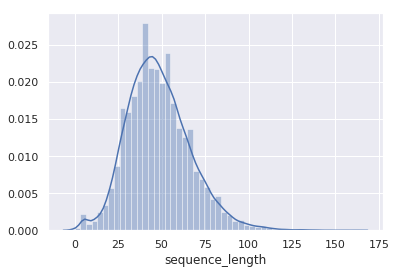

In [29]:
import seaborn as sns

data=pd.DataFrame()
data["sequence_length"] = df["Captions"].apply(len)

sns.set()
distribution = sns.distplot(data["sequence_length"])

In [30]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

def padding_train_sequences(train_seqs,max_length,padding_type):
  cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
  return cap_vector

cap_vector= padding_train_sequences(train_seqs,max_length,'post')

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40000, 35)


In [31]:
cap_vector

array([[  3, 184,  60, ...,   0,   0,   0],
       [  3,   2,  12, ...,   0,   0,   0],
       [  3,   2,  15, ...,   0,   0,   0],
       ...,
       [  3,   2,  20, ...,   0,   0,   0],
       [  3,   2,  17, ...,   0,   0,   0],
       [  3,   2, 152, ...,   0,   0,   0]], dtype=int32)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [32]:
# Lets check the shape of the images
def find_img_shape(image):
    img= plt.imread(image)
    
    print("Shape of {0}: {1}".format(image.split('/')[1],img.shape))
    
img_list=[]
for i in range(5):
    img_list.append(img_name_vector[i])

for j in img_list:
    find_img_shape(j)

Shape of Images: (500, 375, 3)
Shape of Images: (375, 500, 3)
Shape of Images: (375, 500, 3)
Shape of Images: (400, 500, 3)
Shape of Images: (274, 500, 3)


Shape of the image:(375, 500, 3)


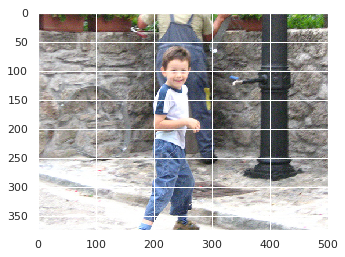

In [33]:
# To know the shape of images
def image_and_shapes(image):
  img= plt.imread(image)
  plt.imshow(img)
  print("Shape of the image:{}".format(img.shape))

image_and_shapes("Flickr8K/Images/1015118661_980735411b.jpg")

W0103 14:40:32.044283 139778707789632 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)


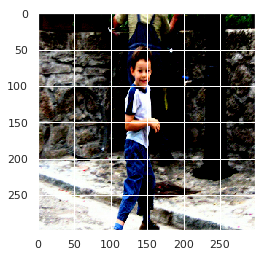

In [34]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path

img1,img1_path = load_image("Flickr8K/Images/1015118661_980735411b.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [35]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Use set operation to get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(BUFFER_SIZE).batch(64, drop_remainder=True)

In [36]:
print(image_dataset)

<BatchDataset shapes: ((64, 299, 299, 3), (64,)), types: (tf.float32, tf.string)>


In [37]:
# # Create training and test set using an 80-20 split
img_name_train, img_name_test, caption_train, caption_test = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=42)

In [38]:
len(img_name_train), len(caption_train), len(img_name_test), len(caption_test)

(32000, 32000, 8000, 8000)

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [39]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input =  image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [40]:
# Save the image files to numpy format
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [41]:
def create_dataset(img_name,caption):
  
  dataset = tf.data.Dataset.from_tensor_slices((img_name, caption))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [42]:
# Creating train and test dataset
train_dataset = create_dataset(img_name_train,caption_train)
test_dataset = create_dataset(img_name_test,caption_test)

In [43]:
print("For Train_dataset:")
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

print("For Test_dataset:")
sample_img_batch_test, sample_cap_batch_test = next(iter(test_dataset))
print(sample_img_batch_test.shape)
print(sample_cap_batch_test.shape)

For Train_dataset:
(64, 64, 2048)
(64, 35)
For Test_dataset:
(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [44]:
embedding_dim = 256 
units = 512
vocab_size = len(tokenizer.word_index) + 1 #top 5,000 words +1
train_num_steps = len(img_name_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(img_name_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE
attention_features_shape = 64

### Encoder

In [45]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [46]:
encoder=Encoder(embedding_dim)
encoder

### Attention model

In [47]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis) + self.W2(features))) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)

        return context_vector, attention_weights

### Decoder

In [49]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #initalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(units) #build your Dense layer
        
#         self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
#         self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
        
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        # Adding Dropout and BatchNorm Layers
#         output = self.dropout(output)
#         output = self.batchnormalization(output)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [50]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [51]:
sample_img_batch

<tf.Tensor: shape=(64, 64, 2048), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.98881084, 0.        , 0.19691503, ..., 0.        ,
         0.        , 0.09451069],
        [2.8607397 , 0.        , 0.87621874, ..., 0.        ,
         0.        , 0.07939251],
        ...,
        [0.2786056 , 0.        , 0.11168797, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.20203818, 0.        ]],

       [[0.8380418 , 0.        , 0.4909584 , ..., 0.        ,
         0.        , 0.        ],
        [0.13945451, 0.        , 0.2568598 , ..., 0.        ,
         0.        , 0.07845404],
        [0.        , 0.        , 0.18672104, ..., 0.        ,
         0.60453886, 0.3074214 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.

In [52]:
sample_cap_batch

<tf.Tensor: shape=(64, 35), dtype=int32, numpy=
array([[   3,    2,   39, ...,    0,    0,    0],
       [   3,   14,   23, ...,    0,    0,    0],
       [   3, 3892,   13, ...,    0,    0,    0],
       ...,
       [   3,    2,   51, ...,    0,    0,    0],
       [   3,    2,   26, ...,    0,    0,    0],
       [   3,    2,   12, ...,    0,    0,    0]], dtype=int32)>

In [53]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 8291)
Attention weights shape from Decoder: (64, 64, 1)


In [56]:
def Encoder_features(img_tensor, target):
    features = encoder(img_tensor)
    return features,target,img_tensor

for (batch, (img_tensor, target)) in enumerate(train_dataset):
    features,target,img_tensor = Encoder_features(img_tensor, target)

In [57]:
target.shape # (batch_size,max_length)

TensorShape([64, 35])

In [58]:
img_tensor.shape #(batch_size,attention_feature_shape,feature_shape)

TensorShape([64, 64, 2048])

In [59]:
features.shape #(batch_size,attention_feature_shape,feature_shape)

TensorShape([64, 64, 256])

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [60]:
optimizer = tf.keras.optimizers.Adam() #defining the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') #defining the loss object

In [61]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [62]:
checkpoint_path = "./training_checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
checkpoint_path_ckpt = os.path.join(checkpoint_path, "ckpt")
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=10)

In [63]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [64]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [65]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # predictions : (64,8329)
        loss += loss_function(target[:, i], predictions)
        predicted_id = tf.argmax(predictions[0])
        dec_input = tf.expand_dims([predicted_id] * BATCH_SIZE, 1)
        
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [66]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss = total_loss / test_num_steps
    
    return avg_test_loss

In [69]:
loss_plot = []
test_loss_plot = []

In [70]:
EPOCHS = 15
from tqdm import tqdm
import time
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    print('Training......')
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    avg_train_loss=total_loss / train_num_steps
    print('Train avg_loss: ', avg_train_loss)
        
    loss_plot.append(avg_train_loss) 
    print('Testing.......')
    test_loss = test_loss_cal(test_dataset)
    print('Test avg_loss: ', test_loss)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()


  0%|          | 0/15 [00:00<?, ?it/s]

Training......
Train avg_loss:  tf.Tensor(1.0509316, shape=(), dtype=float32)
Testing.......
Test avg_loss:  tf.Tensor(2.0816991, shape=(), dtype=float32)
For epoch: 1, the train loss is 1.051, & test loss is 2.082
Time taken for 1 epoch 208.58351373672485 sec

Test loss has been reduced from 100.000 to 2.082



  7%|▋         | 1/15 [03:29<48:51, 209.41s/it]

Training......
Train avg_loss:  tf.Tensor(0.95174474, shape=(), dtype=float32)
Testing.......
Test avg_loss:  tf.Tensor(2.0598974, shape=(), dtype=float32)
For epoch: 2, the train loss is 0.952, & test loss is 2.060
Time taken for 1 epoch 193.98803305625916 sec

Test loss has been reduced from 2.082 to 2.060



 13%|█▎        | 2/15 [06:44<44:25, 205.03s/it]

Training......
Train avg_loss:  tf.Tensor(0.8829942, shape=(), dtype=float32)
Testing.......



 20%|██        | 3/15 [09:57<40:19, 201.64s/it]

Test avg_loss:  tf.Tensor(2.0599325, shape=(), dtype=float32)
For epoch: 3, the train loss is 0.883, & test loss is 2.060
Time taken for 1 epoch 193.74471306800842 sec

Training......
Train avg_loss:  tf.Tensor(0.82654667, shape=(), dtype=float32)
Testing.......



 27%|██▋       | 4/15 [13:11<36:32, 199.32s/it]

Test avg_loss:  tf.Tensor(2.088872, shape=(), dtype=float32)
For epoch: 4, the train loss is 0.827, & test loss is 2.089
Time taken for 1 epoch 193.878324508667 sec

Training......
Train avg_loss:  tf.Tensor(0.7768447, shape=(), dtype=float32)
Testing.......



 33%|███▎      | 5/15 [16:25<32:57, 197.73s/it]

Test avg_loss:  tf.Tensor(2.1766436, shape=(), dtype=float32)
For epoch: 5, the train loss is 0.777, & test loss is 2.177
Time taken for 1 epoch 194.01653814315796 sec

Training......
Train avg_loss:  tf.Tensor(0.7311648, shape=(), dtype=float32)
Testing.......



 40%|████      | 6/15 [19:39<29:28, 196.50s/it]

Test avg_loss:  tf.Tensor(2.1860597, shape=(), dtype=float32)
For epoch: 6, the train loss is 0.731, & test loss is 2.186
Time taken for 1 epoch 193.64122581481934 sec

Training......
Train avg_loss:  tf.Tensor(0.6886843, shape=(), dtype=float32)
Testing.......



 47%|████▋     | 7/15 [22:53<26:05, 195.72s/it]

Test avg_loss:  tf.Tensor(2.2939715, shape=(), dtype=float32)
For epoch: 7, the train loss is 0.689, & test loss is 2.294
Time taken for 1 epoch 193.8798942565918 sec

Training......
Train avg_loss:  tf.Tensor(0.6499013, shape=(), dtype=float32)
Testing.......



 53%|█████▎    | 8/15 [26:07<22:45, 195.14s/it]

Test avg_loss:  tf.Tensor(2.3161016, shape=(), dtype=float32)
For epoch: 8, the train loss is 0.650, & test loss is 2.316
Time taken for 1 epoch 193.80043148994446 sec

Training......
Train avg_loss:  tf.Tensor(0.612499, shape=(), dtype=float32)
Testing.......



 60%|██████    | 9/15 [29:21<19:28, 194.75s/it]

Test avg_loss:  tf.Tensor(2.4179175, shape=(), dtype=float32)
For epoch: 9, the train loss is 0.612, & test loss is 2.418
Time taken for 1 epoch 193.82953071594238 sec

Training......
Train avg_loss:  tf.Tensor(0.5782345, shape=(), dtype=float32)
Testing.......



 67%|██████▋   | 10/15 [32:35<16:12, 194.53s/it]

Test avg_loss:  tf.Tensor(2.4595137, shape=(), dtype=float32)
For epoch: 10, the train loss is 0.578, & test loss is 2.460
Time taken for 1 epoch 194.0125813484192 sec

Training......
Train avg_loss:  tf.Tensor(0.54776186, shape=(), dtype=float32)
Testing.......



 73%|███████▎  | 11/15 [35:48<12:57, 194.35s/it]

Test avg_loss:  tf.Tensor(2.58074, shape=(), dtype=float32)
For epoch: 11, the train loss is 0.548, & test loss is 2.581
Time taken for 1 epoch 193.92325258255005 sec

Training......
Train avg_loss:  tf.Tensor(0.5172236, shape=(), dtype=float32)
Testing.......



 80%|████████  | 12/15 [39:02<09:42, 194.20s/it]

Test avg_loss:  tf.Tensor(2.591134, shape=(), dtype=float32)
For epoch: 12, the train loss is 0.517, & test loss is 2.591
Time taken for 1 epoch 193.83879041671753 sec

Training......
Train avg_loss:  tf.Tensor(0.49087617, shape=(), dtype=float32)
Testing.......



 87%|████████▋ | 13/15 [42:16<06:28, 194.14s/it]

Test avg_loss:  tf.Tensor(2.7222154, shape=(), dtype=float32)
For epoch: 13, the train loss is 0.491, & test loss is 2.722
Time taken for 1 epoch 193.99673461914062 sec

Training......
Train avg_loss:  tf.Tensor(0.46472362, shape=(), dtype=float32)
Testing.......



 93%|█████████▎| 14/15 [45:30<03:14, 194.08s/it]

Test avg_loss:  tf.Tensor(2.7853417, shape=(), dtype=float32)
For epoch: 14, the train loss is 0.465, & test loss is 2.785
Time taken for 1 epoch 193.95949530601501 sec

Training......
Train avg_loss:  tf.Tensor(0.4422721, shape=(), dtype=float32)
Testing.......



100%|██████████| 15/15 [48:44<00:00, 193.96s/it]

Test avg_loss:  tf.Tensor(2.8206596, shape=(), dtype=float32)
For epoch: 15, the train loss is 0.442, & test loss is 2.821
Time taken for 1 epoch 193.65671110153198 sec



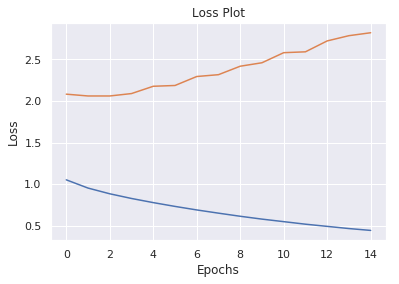

In [71]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

3.Test it on a sample data using BLEU score

### Greedy Search

In [72]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [73]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [74]:
from nltk.translate.bleu_score import sentence_bleu

In [75]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BLEU score: 46.725603347714525
Real Caption: a snowboarder is in the air above a ramp of snow
Prediction Caption: a snowboarder glides through the air above a snowy hill


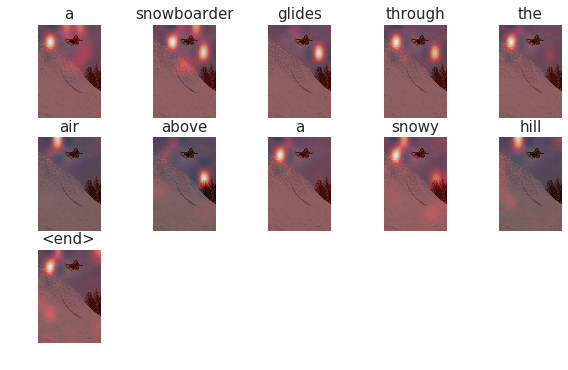

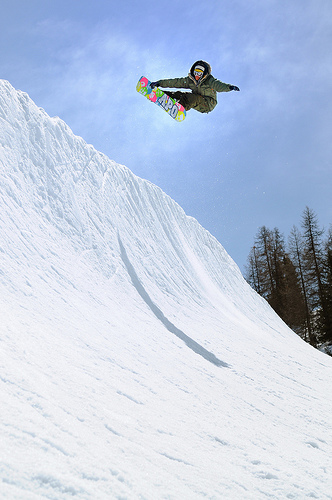

In [108]:
rid = np.random.randint(0, len(img_name_test))
test_image = img_name_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))#set your weights)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [110]:
# im1 = Image.open(test_image)
# im2 = Image.open(test_image)
# im3 = Image.open(test_image)
# im4 = Image.open(test_image)
# im5 = Image.open(test_image)
# im6 = Image.open(test_image)
# im7 = Image.open(test_image)
# im8 = Image.open(test_image)
# im9 = Image.open(test_image)
# im10 = Image.open(test_image)

## Sample predictions listed here:

1. BLEU score: 9.308300767049977e-153
   
   Real Caption: two husky like white dogs are outside on snow
    
   Prediction Caption: two white furry dogs play in the snow
   
   
2. BLEU score: 5.154827976372712e-153
   
   Real Caption: two dogs playfully bite a third dog

   Prediction Caption: three dogs are biting each other
   

3. BLEU score: 13.801311186847082

   Real Caption: a boy wearing a life vest suspended in the air
   
   Prediction Caption: a boy in an orange jersey and is holding onto a track during a competition
   

4.  BLEU score: 3.9032633099964214e-153
    
    Real Caption: two boys are back to back as one holds up the other
    
    Prediction Caption: one man lifts another on his back
    

5. BLEU score: 4.306075028866568e-153
   
   Real Caption: a religious gathered together
   
   Prediction Caption: a large group of people are waiting in front of a church
   

6. BLEU score: 5.991755122558557e-153
   
   Real Caption: the brown and black dog has his mouth open
   
   Prediction Caption: brown dog barking at something off camera
   

7. BLEU score: 7.458340731200295e-153
   
   Real Caption: a large dog chases a boy through a field
   
   Prediction Caption: a woman frolic in a blue shirt with a black dog on a green green grass   
   

8. BLEU score: 36.05147093430547

   Real Caption: a bearded man is riding a bicycle on the beach

   Prediction Caption: man are riding a bicycle off a beach
   

9. BLEU score: 12.76119215161368
   
   Real Caption: a basketball player wearing a red and white jersey while running down the court
   
   Prediction Caption: the north carolina basketball player dribbles by block him to grab him
   

10. BLEU score: 46.725603347714525

    Real Caption: a snowboarder is in the air above a ramp of snow

    Prediction Caption: a snowboarder glides through the air above a snowy hill

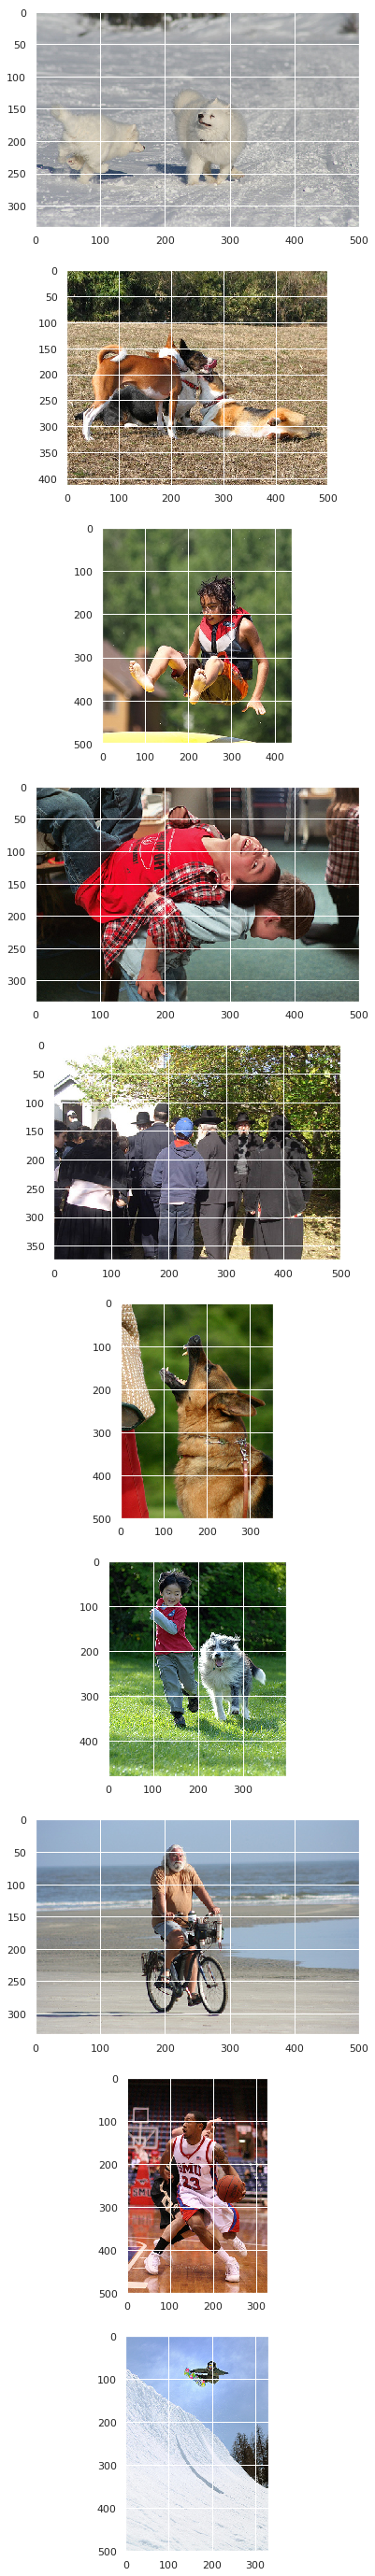

In [124]:
# for the above 10 sample outputs (real and predicted captions), below are the image in the same order.

imgs = [im1, im2, im3, im4, im5, im6, im7, im8, im9, im10]
_, axs = plt.subplots(10, 1, figsize=(500, 50))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
#
plt.show()